In [12]:
import math 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [216]:
STEADY_THRESHOLD = 0.0001
TIME_RANGE = 100

def library_parser(data):
    features = model.feature_library.get_feature_names()
    n = len(data)
    m = len(features)
    
    result = [None] * m
    for i in range(0, m):
        r = 1
        for elm in features[i].split(' '):
            var_index = None
            power = 1
            if 'x' in elm:
                elm = elm.replace('x', '')
                if '^' in elm:
                    var_index = int(elm.split('^')[0])
                    power = int(elm.split('^')[1])
                else:
                    var_index = int(elm)
                r = r * pow(data[var_index], power) 
        result[i] = r
    return result


def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -STEADY_THRESHOLD < max(np.amax(diff), np.amin(diff), key=abs) < STEADY_THRESHOLD:
            return state
        
def sindy(data, t):
    coefficients = model.coefficients()
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

def create_perturbed_state(alpha, perturbed_node, steady_state):
    perturbation = np.zeros(number_of_nodes)
    perturbation[perturbed_node] = (steady_state[perturbed_node] if steady_state[perturbed_node] > 0 else 1) * alpha
    perturbed = np.add(steady_state, perturbation)

def apply_perturbation(perturbed, dynamic_func):
    t_perturbed = np.arange(0, TIME_RANGE, dt)
    x_perturbed = odeint(dynamic_func, perturbed, t_perturbed)
    return x_perturbed

def flow(X, start=0, stop=float('inf')):
    prev_state = X[0]
    result = [prev_state]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        if start < i < stop:
            temp = [min(abs(s),100) for s in state]
            result = np.vstack((result, temp))
        prev_state = state
        if -STEADY_THRESHOLD < max(np.amax(diff), np.amin(diff), key=abs) < STEADY_THRESHOLD:
            return result
    print('chaos state')
    return result

def plot_flow(flow, mode, size=(16, 9)):
    plt.figure(1)
    plt.rcParams["figure.figsize"] = size
    if mode == 'single':
        for i in range(0,number_of_nodes):
            plt.plot(flow[:,i], label='x'+str(i))
        plt.legend()
    elif mode == 'multi':
        fpr = 2
        fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
        for i in range(0,number_of_nodes):
            axsi = axs[int(i/fpr), i%fpr]
            axsi.plot(flow[:,i])
            axsi.set_title('x'+str(i))
    plt.show()
    
    
def calculate_g(alpha, steady_state, dynamic_func):
    g_matrix = np.empty((number_of_nodes,number_of_nodes))
    t_perturbed = np.arange(0, TIME_RANGE, dt)
    
    for i in range(0, number_of_nodes):
        perturbation_i = np.zeros(number_of_nodes)
        perturbation_i[i] = steady_state[i] * alpha
        perturbed_i = np.add(steady_state, perturbation_i[i])

        x_perturbed_i = odeint(dynamic_func, perturbed_i, t_perturbed)
        final_state_i = x_perturbed_i[-1]
        diff_i = np.subtract(final_state_i, steady_state)

        dxi_xi = diff_i[i]/steady_state[i]
        for j in range(0, number_of_nodes):
            dxj_xj = diff_i[j]/steady_state[j]
            g_matrix[i,j] = abs(dxi_xi/dxj_xj)
    
    return g_matrix

def find_g_dist(g_matrix):
    g_dist = []
    for row in g_matrix:
        for gij in row:
            g_dist.append(gij)
    return g_dist

def calculate_f(g_matrix):
    f = np.zeros(number_of_nodes)
    logf = np.zeros(number_of_nodes)
    for i in range(0, number_of_nodes):
        f_i = np.zeros(number_of_nodes)
        for n in range(0, number_of_nodes):
            sum_gmn = 0
            for m in range(0, number_of_nodes):
                sum_gmn += g_matrix[m,n]
            sum_gmi = 0
            for m in range(0, number_of_nodes):
                if i==m:
                    continue
                sum_gmi += g_matrix[m,i]/sum_gmn
            f_i[n] = g_matrix[i,n] * sum_gmi

        for n in range(0, number_of_nodes):
            if i==n:
                continue
            f[i] += f_i[n]
        f[i] /= (number_of_nodes-1)
        logf[i] = math.log(f[i], graph.degree[i])
    
    return f, logf

def flow_prediction_error(predict, base, limit):
    sum_error = [0] * number_of_nodes
    for i in range(0,limit):
        for n in range(0, number_of_nodes):
            sum_error[n] += abs(predict[i][n] - base[i][n])/base[i][n]
    return [se/limit for se in sum_error]

In [15]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/financial-b1.csv')

In [189]:
number_of_nodes = 8
offset = 16
exclude = [3, 22]

matrix = []
for row in df.values:
    prow = []
    for i, x in enumerate(row):
        if i not in exclude:
            prow.append(x/1000)
    matrix.append(np.array(prow[1+offset:offset+number_of_nodes+1]))
matrix = np.array(matrix)
    
train_size = int(len(matrix) * 0.8)
train = matrix[:train_size] 
future = matrix[train_size:]
print(len(matrix), len(train), len(future))

290 232 58


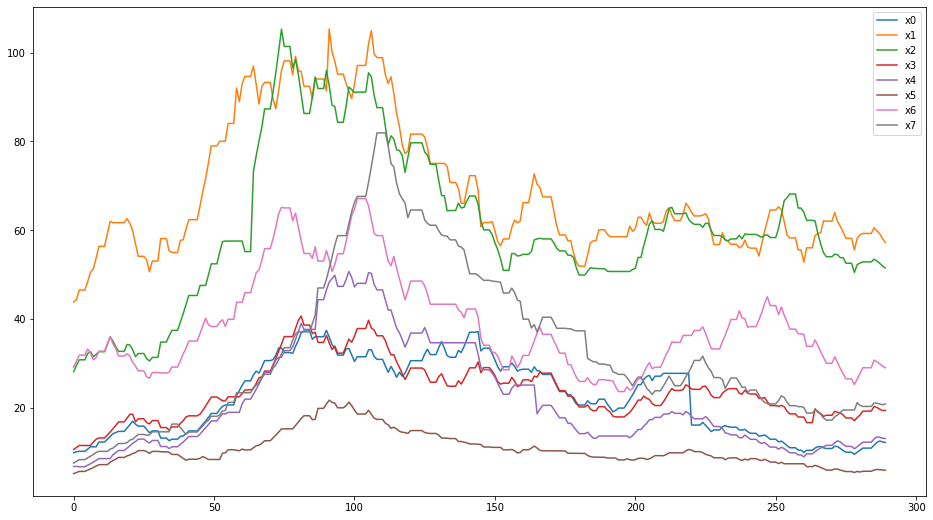

In [190]:
plot_flow(matrix, 'single')

In [191]:
import pysindy as ps

dt = 0.01

model = ps.SINDy()
model.fit(train, t=dt)
model.print()

x0' = 501.931 1 + -13.409 x0 + -26.871 x1 + 36.066 x2 + -34.324 x3 + -44.682 x4 + 7.322 x5 + 15.994 x6 + 12.318 x7 + -3.477 x0^2 + 1.820 x0 x1 + 1.547 x0 x2 + 4.104 x0 x3 + 5.187 x0 x4 + 6.143 x0 x5 + -7.162 x0 x6 + -1.438 x0 x7 + 0.165 x1^2 + -0.795 x1 x2 + -0.663 x1 x3 + -2.512 x1 x4 + 3.996 x1 x5 + 0.689 x1 x6 + 0.424 x1 x7 + -0.278 x2^2 + -0.428 x2 x3 + 2.178 x2 x4 + -8.595 x2 x5 + 2.140 x2 x6 + -0.355 x2 x7 + -1.978 x3^2 + -3.870 x3 x4 + 0.916 x3 x5 + 4.291 x3 x6 + 0.353 x3 x7 + 4.975 x4 x5 + 1.635 x4 x6 + -1.344 x4 x7 + -11.643 x5^2 + 1.542 x5 x6 + 2.315 x5 x7 + -2.265 x6^2 + -0.162 x6 x7 + 0.273 x7^2
x1' = -703.321 1 + 185.600 x0 + 0.201 x1 + -28.044 x2 + 213.005 x3 + -140.115 x4 + -517.772 x5 + 64.794 x6 + 0.039 x7 + -4.984 x0^2 + 0.982 x0 x1 + 4.040 x0 x2 + -6.491 x0 x3 + 7.006 x0 x4 + -15.866 x0 x5 + -4.387 x0 x6 + 2.371 x0 x7 + 0.238 x1^2 + -1.659 x1 x2 + -1.658 x1 x3 + 2.032 x1 x5 + 0.842 x1 x6 + 0.945 x1 x7 + -0.297 x2^2 + -2.278 x2 x3 + -2.903 x2 x4 + 7.586 x2 x5 + 3.566 

In [194]:
# perturbed = create_perturbed_state(2, 8, steady_state)
perturbed = future[0]
x_perturbed = apply_perturbation(perturbed, sindy)
perturbed_steady_state = find_steady_state(x_perturbed)
print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: None


chaos state


<Figure size 1152x648 with 0 Axes>

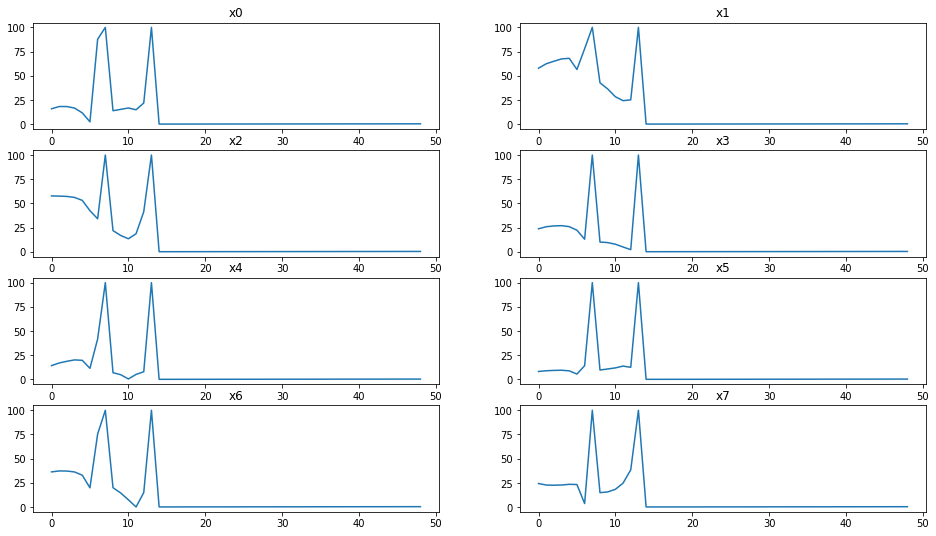

In [217]:
x_flow = flow(x_perturbed, start=1, stop=50)
plot_flow(x_flow, 'multi')

<Figure size 1152x648 with 0 Axes>

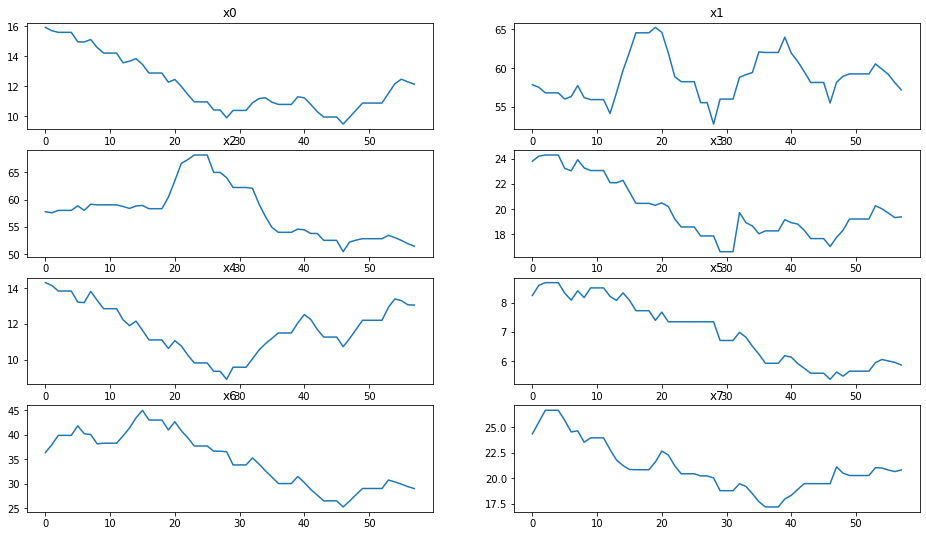

In [196]:
plot_flow(future, 'multi')

[0.0, 0.04351239469835683, 0.07416260092120162, 0.09293529461504892, 0.10802374541298594, 0.13665747984563462, 0.30927358409178607, 0.7694150902005625, 0.7253733411330296, 0.6976358954052213, 0.6854361118344358, 0.673434673666894, 0.6652170323863003, 0.9313236445791478, 0.9354654533767858, 0.9390520160173778, 0.9421747016285077, 0.9449254146188766, 0.9473628875075519, 0.949521072031305, 0.9514661633329153, 0.9531998354185524, 0.9547474179243626, 0.9561329184266023, 0.9573879526887852, 0.958527574507841, 0.9595495995152419, 0.96048056952397, 0.9613175607003326, 0.9620718191655009, 0.9627604141444699, 0.963389501589071, 0.9639935953600536, 0.9645462030304265, 0.9650447054453366, 0.9654892753683587, 0.9658854974490351, 0.9662469267056242, 0.9665762395092097, 0.9668987983802628, 0.9671930374830854, 0.9674488566471956, 0.9676659297455894, 0.9678442672839898, 0.9680024416620334, 0.9681417678684393, 0.9682411926390403]


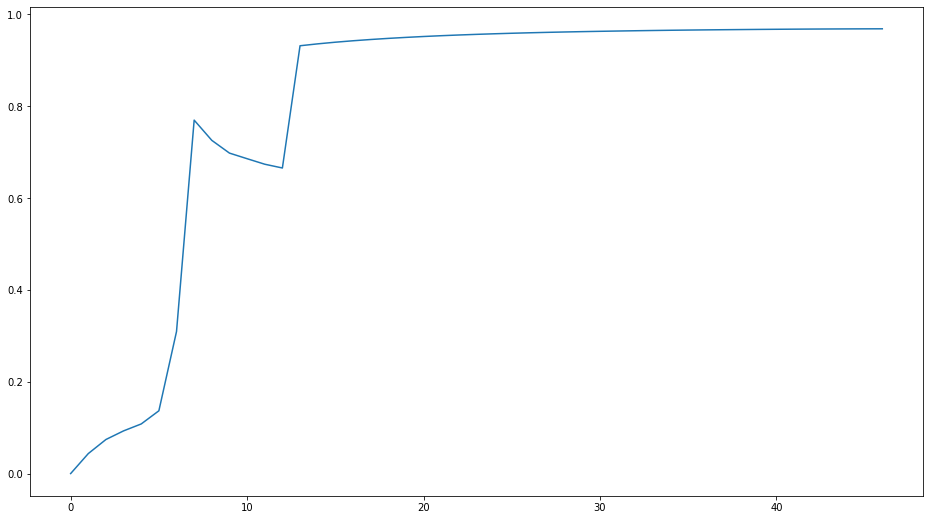

In [214]:
prediction_error_matrix = [flow_prediction_error(x_flow, future, i) for i in range(1,48)]
prediction_error = [sum(error)/number_of_nodes for error in prediction_error_matrix]

#print(prediction_error_matrix)
print(prediction_error)
plt.figure(2)
plt.plot(prediction_error)